In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
from ellipse import LsqEllipse
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from skimage import io
import matplotlib.pyplot as plt
import math
import pickle
import statistics
from statistics import mean
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks

from numpy import arange
from pandas import read_csv
from scipy.optimize import curve_fit
from matplotlib import pyplot
import pickle

In [2]:
import sys
import sys
sys.path.append('../')
from inference.read_in_data import *
from inference.correlation_heatmap import *
from inference.calculating_tau import *
from inference.dedrift import *

In [3]:
def compute_g2t_wo_kernel(px,laglist_g2t,normalize=True):
    intensity=[]
    for t in range(0,img.shape[0],1):
        intensity.append(img[t][px[0],px[1]])
        
    g2t=np.zeros(len(laglist_g2t))
    for lag in laglist_g2t:
        numerator=[]
        denumerator1=[]
        denumerator2=[]
        max_t_range=len(intensity)-lag
        for t in range(0,max_t_range,1):
            numerator.append(int(intensity[t])*int(intensity[t+lag]))
            denumerator1.append(intensity[t])
            denumerator2.append(intensity[t+lag])
        g2t[lag]=(np.array(numerator).mean()/np.array(denumerator1).mean()/np.array(denumerator2).mean())-1
        #g2t[lag]=g2t[lag]/g2t[0]
    if normalize:
        first=g2t[0]
        for lag in laglist_g2t:
            g2t[lag]=g2t[lag]/first
    return g2t

# Viscosity of 0.05% glycerol (4 uL glycerol + 196 uL)

viscosity from Rheometer data: 0.588 Pa*S

In [4]:
#expected D
kb=1.380649*10**(-23) # J*K^(-1)
T=300 # K
eta=0.59 # Pa*S
r=52*10**(-9) # m
D=kb*T/(6*math.pi*eta*r) #m^2/s
print(D) #m^2/s

7.16222663053723e-15


In [135]:
#expected D
kb=1.380649*10**(-23) # J*K^(-1)
T=300 # K
eta=0.65 # Pa*S
r=52*10**(-9) # m
D=kb*T/(6*math.pi*eta*r) #m^2/s
print(D) #m^2/s

6.5010980184876395e-15


viscosity measured using DLS is 0.6498021636129446 Pa*s

# 0.05% 100nm in diameter PS beads in glycerol

## 10x Objective

In [227]:
video_time_length=30 #s
imgname='0p05ps_beads_inglycerol_405laser_10xobj_0p52au_30s_2avg'
foldername='/Volumes/WENYUN WANG/20221129/0p05_PSbeads_in_glycerol/'

In [228]:
# read the image stack
img = io.imread(foldername+imgname+'.tif')
frame_number=img.shape[0]
img_height=img.shape[1]
img_width=img.shape[2]
framespeed=video_time_length/frame_number

In [229]:
print(framespeed)

0.005857087075361187


In [8]:
laglist_g2t=range(0,500,1)
averaged_g2t=[]
for y in range(1,19,1):
    for x in range(10,40,1):
        px=[y,x]
        g2t=compute_g2t_wo_kernel(px,laglist_g2t)
        averaged_g2t.append(g2t)

In [9]:
average_g2t=np.mean(averaged_g2t,axis=0)
pickle.dump(average_g2t, open(foldername+imgname+'_g2tcorrrelation_avg_temperal.p',"wb"))

In [87]:
average_g2t=pickle.load(open(foldername+imgname+'_g2tcorrrelation_avg_temperal.p', "rb"))
laglist_g2t=range(0,len(average_g2t),1)
lagtime_g2t= [element * framespeed for element in laglist_g2t]

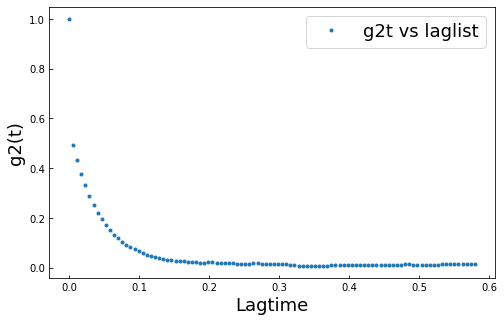

In [88]:
plt.figure(figsize=(8,5))
plt.plot(lagtime_g2t[0:100],average_g2t[0:100],'.')
plt.legend(['g2t vs laglist'], fontsize=18)
plt.xlabel("Lagtime",fontsize=18)
plt.ylabel("g2(t)",fontsize=18)
plt.tick_params(direction='in')

tau is: 0.04409295560983067
y = -22.67936 * x + -0.57633


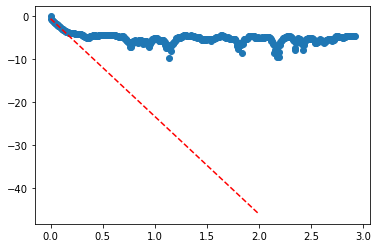

R square is 0.9999596963993119


In [89]:
lagtime_g2t= [element * framespeed for element in laglist_g2t]
plateau=0#np.mean(average_g2t[100:200])
tau, a, b=fit_exponential_decay_rsq(plateau,np.array(average_g2t),lagtime_g2t,1,10, True)

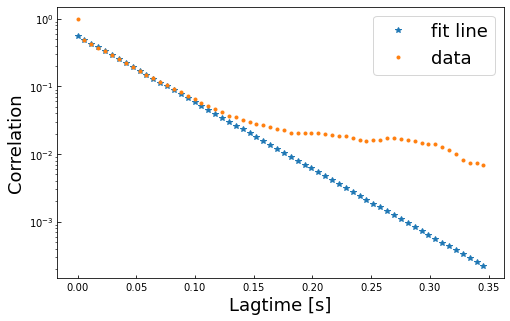

In [90]:
reconstruct(lagtime_g2t[0:60],plateau,np.array(average_g2t[0:60]),a,b)
#plt.ylim(0,0.1)
#plt.xlim(0,lagtime_g2t[20])
plt.yscale("log")

In [91]:
n=1.47
angle=np.arange(180-19.77,180+19.77,1)
lamda=405 #nm
k=2*math.pi/lamda
q=2*k*np.sin(np.radians(angle/2))*10**(9)*n

q=np.mean(q)
D=a/(-2*q**2)
print(D)

5.5064331635492186e-15


# TRC

In [145]:
# for one pixel
def TRC(pixel,kernel_size_y, kernel_size_x, t_interest, tau_interest,normalize=True):
    correlation_2d=np.zeros((len(t_interest),len(tau_interest)))
    total_tlength=len(t_interest)+len(tau_interest)
    # get intensity data
    intensity=np.zeros((total_tlength, 2*kernel_size_y, 2*kernel_size_x))
    y=pixel[0]
    x=pixel[1]
    for yindex,i in enumerate(range(y-kernel_size_y, y+kernel_size_y)):
        for xindex, j in enumerate(range(x-kernel_size_x, x+kernel_size_x)):
            for t in range(total_tlength):
                intensity[t,yindex,xindex]=img[t,i,j]
    value=(2*kernel_size_x)*(2*kernel_size_y)
    intensity=np.reshape(intensity,(total_tlength, value))
    print(intensity.shape)
    # compute correlation
    for t in t_interest:
        for tau in tau_interest:
            numerator=[]
            denum1=[]
            denum2=[]
            for i in range(intensity.shape[1]):
                It=intensity[t,i]
                Ittau=intensity[t+tau,i]
                numerator.append(It*Ittau)
                denum1.append(It)
                denum2.append(Ittau)
            correlation_2d[t,tau]=np.array(numerator).mean()/(np.array(denum1).mean()*np.array(denum2).mean())-1
        if normalize:
            first=correlation_2d[t,0]
            for tau in tau_interest:
                correlation_2d[t,tau]=correlation_2d[t,tau]/first
    return correlation_2d

In [ ]:
laglist_g2t=range(0,50,1)
t_range=range(0,500,1)
TRC_corr=TRC([10,225],10,225,t_range,laglist_g2t)

In [148]:
pickle.dump(TRC_corr, open(foldername+imgname+'_g2tcorrrelation_avg_TRC.p',"wb"))

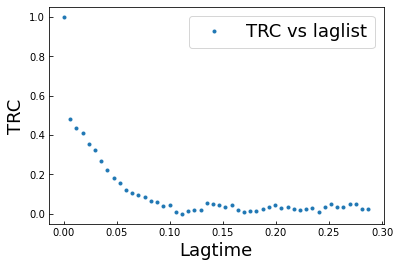

In [252]:
laglist_g2t=range(0,50,1)
lagtime_g2t= [element * framespeed for element in laglist_g2t]
plt.plot(lagtime_g2t,TRC_corr[10,:],'.')
plt.legend(['TRC vs laglist'], fontsize=18)
plt.xlabel("Lagtime",fontsize=18)
plt.ylabel("TRC",fontsize=18)
plt.tick_params(direction='in')

tau is: 0.04083563804795735
y = -24.48841 * x + -0.50386


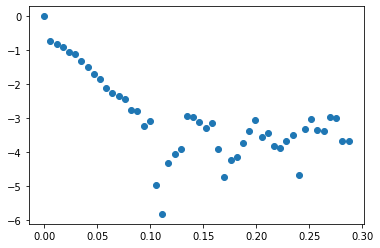

R square is 0.9771773223007102


In [253]:
lagtime_g2t= [element * framespeed for element in laglist_g2t]
plateau=0#np.mean(average_g2t[100:200])
tau, a, b=fit_exponential_decay_rsq(plateau,np.array(TRC_corr[10,:]),lagtime_g2t,1,10, True)

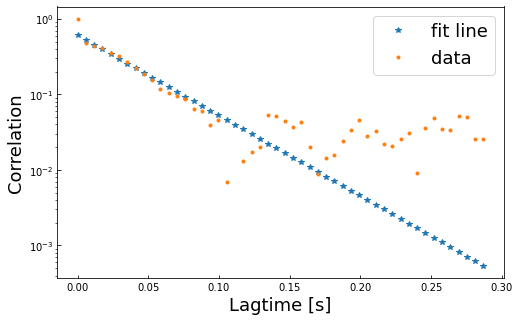

In [254]:
reconstruct(lagtime_g2t[0:50],plateau,np.array(TRC_corr[10,:]),a,b)
plt.yscale("log")

In [255]:
n=1.47
angle=np.arange(180-19.77,180+19.77,1)
lamda=405 #nm
k=2*math.pi/lamda
q=2*k*np.sin(np.radians(angle/2))*10**(9)*n

q=np.mean(q)
D=a/(-2*q**2)
print(D)

5.945662285568723e-15


# Average over spatial and temporal

In [69]:
# for one pixel
def spatial_temporal(pixel,kernel_size_y, kernel_size_x, t_interest, tau_interest, normalize=True):
    correlation=np.zeros(len(tau_interest))
    
    total_tlength=len(t_interest)+len(tau_interest)
    # get intensity data
    intensity=np.zeros((total_tlength, 2*kernel_size_y, 2*kernel_size_x))
    y=pixel[0]
    x=pixel[1]
    for yindex,i in enumerate(range(y-kernel_size_y, y+kernel_size_y)):
        for xindex, j in enumerate(range(x-kernel_size_x, x+kernel_size_x)):
            for t in range(total_tlength):
                intensity[t,yindex,xindex]=img[t,i,j]
    value=(2*kernel_size_x)*(2*kernel_size_y)
    intensity=np.reshape(intensity,(total_tlength, value))
    print(intensity.shape)
    # compute correlation

    for tau in tau_interest:
        numerator=[]
        denum1=[]
        denum2=[]
        for t in t_interest:
            for i in range(intensity.shape[1]):
                It=intensity[t,i]
                Ittau=intensity[t+tau,i]
                numerator.append(It*Ittau)
                denum1.append(It)
                denum2.append(Ittau)
        correlation[tau]=np.array(numerator).mean()/(np.array(denum1).mean()*np.array(denum2).mean())-1
    if normalize:
        first=correlation[0]
        for tau in tau_interest:
            correlation[tau]=correlation[tau]/first   
    

    return correlation

In [70]:
laglist_g2t=range(0,50,1)
t_range=range(0,500,1)
spatemp_corr=spatial_temporal([10,225],10,225,t_range,laglist_g2t)

(550, 9000)


In [71]:
pickle.dump(spatemp_corr, open(foldername+imgname+'_g2tcorrrelation_avg_spatemp.p',"wb"))

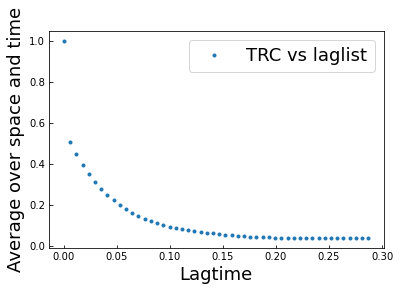

In [251]:
lagtime_g2t= [element * framespeed for element in laglist_g2t]
plt.plot(lagtime_g2t,spatemp_corr[:],'.')
plt.legend(['TRC vs laglist'], fontsize=18)
plt.xlabel("Lagtime",fontsize=18)
plt.ylabel("Average over space and time",fontsize=18)
plt.tick_params(direction='in')

tau is: 0.047474694247960934
y = -21.06385 * x + -0.55443


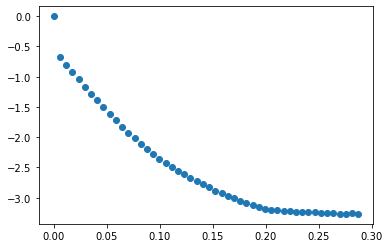

R square is 0.9999877987312751


In [249]:
lagtime_g2t= [element * framespeed for element in laglist_g2t]
plateau=0#np.mean(average_g2t[100:200])
tau, a, b=fit_exponential_decay_rsq(plateau,np.array(spatemp_corr[:]),lagtime_g2t,1,4, True)

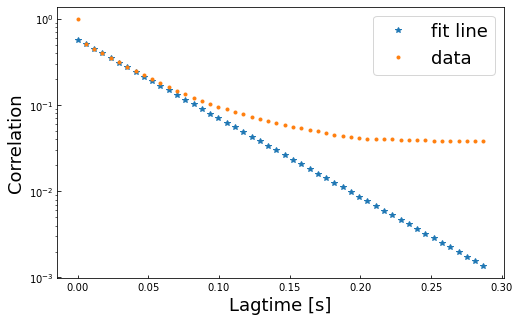

In [250]:
reconstruct(lagtime_g2t[0:50],plateau,np.array(spatemp_corr[:]),a,b)
plt.yscale("log")

In [246]:
n=1.47
angle=np.arange(180-19.77,180+19.77,1)
lamda=405 #nm
k=2*math.pi/lamda
q=2*k*np.sin(np.radians(angle/2))*10**(9)*n

q=np.mean(q)
D=a/(-2*q**2)
print(D)

5.11419645550015e-15


# line scanning

In [258]:
video_time_length=10
imgname='0p05ps_beads_inglycerol_405laser_10xobj_0p52au_10s_2avg_linescan_bidirc'
foldername='/Volumes/WENYUN WANG/20221129/0p05_PSbeads_in_glycerol/'

In [259]:
import czifile
from skimage import io

img = czifile.imread(foldername+imgname+".czi")

In [260]:
img.shape

(1, 34155, 1, 1, 1, 512, 1)

In [261]:
# read the image stack
frame_number=img.shape[1]
img_width=img.shape[5]
framespeed=video_time_length/frame_number

## temporal autocorrelation

In [108]:
def compute_g2t_wo_kernel_line(img,x,laglist_g2t,normalize=True):
    intensity=[]
    for t in range(0,img.shape[1],1):
        intensity.append(img[0,t,0,0,0,x,0])
    plt.plot(intensity[0:50],'-')
        
    g2t=[]
    for lag in laglist_g2t:
        numerator_sum=0
        denumerator_sum_1=0
        denumerator_sum_2=0
        max_t_range=len(intensity)-lag
        for t in range(0,max_t_range,1):
            numerator_sum=numerator_sum+int(intensity[t])*int(intensity[t+lag])
            denumerator_sum_1=denumerator_sum_1+int(intensity[t])
            denumerator_sum_2=denumerator_sum_2+int(intensity[t+lag])
        numerator=numerator_sum/max_t_range
        denumerator_1=denumerator_sum_1/max_t_range
        denumerator_2=denumerator_sum_2/max_t_range
        g2t.append((numerator/denumerator_1/denumerator_2)-1)
    
    if normalize:
        first=g2t[0]
        for lag in laglist_g2t:
            g2t[lag]=g2t[lag]/first
    
    
    return g2t

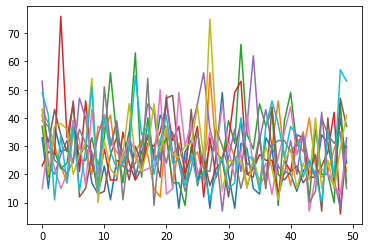

In [115]:
laglist_g2t=range(0,1000,1)
averaged_g2t=[]
for x in range(140,150,1):
    g2t=compute_g2t_wo_kernel_line(img,x,laglist_g2t)
    averaged_g2t.append(g2t)

In [116]:
average_g2t=np.mean(averaged_g2t,axis=0)
pickle.dump(average_g2t, open(foldername+imgname+'_g2tcorrrelation_avg.p',"wb"))

In [117]:
average_g2t=pickle.load(open(foldername+imgname+'_g2tcorrrelation_avg.p', "rb"))
laglist_g2t=range(0,len(average_g2t),1)
lagtime_g2t= [element * framespeed for element in laglist_g2t]

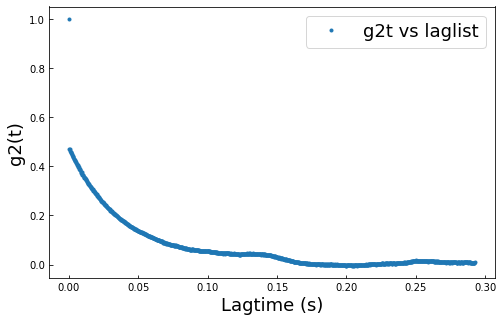

In [134]:
plt.figure(figsize=(8,5))
plt.plot(lagtime_g2t[:],average_g2t[:],'.')
plt.legend(['g2t vs laglist'], fontsize=18)
plt.xlabel("Lagtime (s)",fontsize=18)
plt.ylabel("g2(t)",fontsize=18)
plt.tick_params(direction='in')

tau is: 0.037209105004895535
y = -26.87514 * x + -0.74372


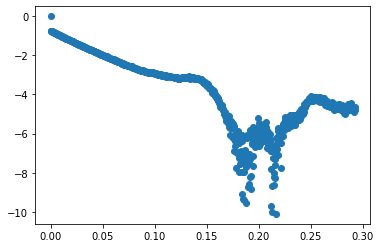

R square is 0.9953819093123164


In [131]:
lagtime_g2t= [element * framespeed for element in laglist_g2t]
plateau=0#np.mean(average_g2t[100:200])
tau, a, b=fit_exponential_decay_rsq(plateau,np.array(average_g2t),lagtime_g2t,1,15, True)

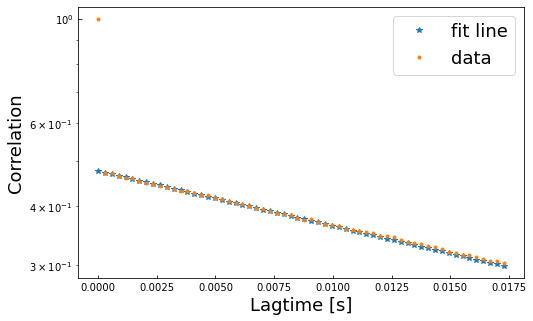

In [132]:
reconstruct(lagtime_g2t[0:60],plateau,np.array(average_g2t[0:60]),a,b)
#plt.ylim(0,0.1)
#plt.xlim(0,lagtime_g2t[20])
plt.yscale("log")

In [133]:
n=1.47
angle=np.arange(180-19.77,180+19.77,1)
lamda=405 #nm
k=2*math.pi/lamda
q=2*k*np.sin(np.radians(angle/2))*10**(9)*n

q=np.mean(q)
D=a/(-2*q**2)
print(D)

6.525147891004932e-15


## Average over spatial and temperol 

In [262]:
def spatial_temporal_line(img, x, kernel_size,t_interest, tau_interest,normalize=True):
    
    
    correlation=np.zeros(len(tau_interest))
    total_tlength=len(t_interest)+len(tau_interest)
    # get intensity data
    intensity=np.zeros((total_tlength, 2*kernel_size))
    for index,i in enumerate(range(x-kernel_size, x+kernel_size)):
        for t in range(total_tlength):
            intensity[t,index]=img[0,t,0,0,0,i,0]
    print(intensity.shape)
        
    for tau in tau_interest:
        numerator=[]
        denum1=[]
        denum2=[]
        for t in t_interest:
            for i in range(intensity.shape[1]):
                It=intensity[t,i]
                Ittau=intensity[t+tau,i]
                numerator.append(It*Ittau)
                denum1.append(It)
                denum2.append(Ittau)
        correlation[tau]=np.array(numerator).mean()/(np.array(denum1).mean()*np.array(denum2).mean())-1
    if normalize:
        first=correlation[0]
        for tau in tau_interest:
            correlation[tau]=correlation[tau]/first   
    

    return correlation

In [263]:
print(img.shape[1])

34155


In [264]:
tau_interest=range(0,1000,1)
t_interest=range(0,15000,1)
averaged_g2t=[]
x=125
g2t=spatial_temporal_line(img,110,100,t_interest,tau_interest)

(16000, 200)


In [280]:
g2t.shape

(1000,)

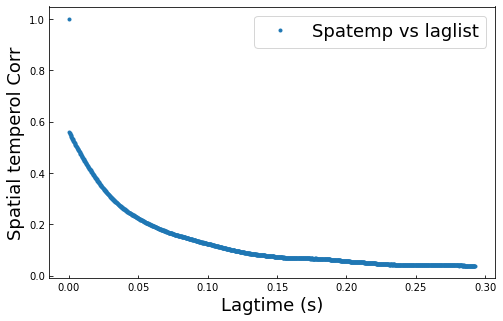

In [297]:
lagtime_g2t=tau_interest
lagtime_g2t= [element * framespeed for element in laglist_g2t]
plt.figure(figsize=(8,5))
plt.plot(lagtime_g2t[:],g2t[:],'.')
plt.legend(['Spatemp vs laglist'], fontsize=18)
plt.xlabel("Lagtime (s)",fontsize=18)
plt.ylabel("Spatial temperol Corr",fontsize=18)
plt.tick_params(direction='in')

tau is: 0.047973212487542466
y = -20.84497 * x + -0.57795


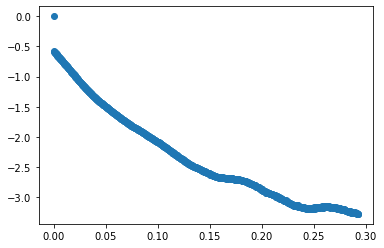

R square is 0.9994695748441534


In [291]:
laglist_g2t=tau_interest
lagtime_g2t= [element * framespeed for element in laglist_g2t]
plateau=0#np.mean(average_g2t[100:200])
tau, a, b=fit_exponential_decay_rsq(plateau,np.array(g2t),lagtime_g2t,1,15, True)

In [290]:
len(lagtime_g2t)

50

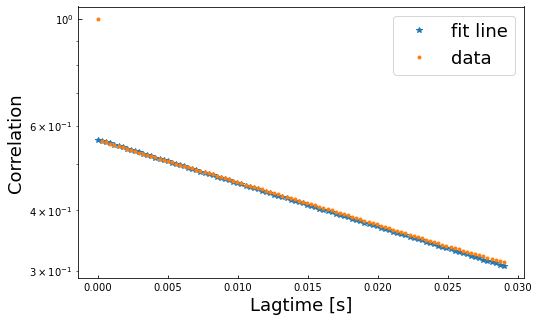

In [294]:
reconstruct(lagtime_g2t[0:100],plateau,np.array(g2t[0:100]),a,b)
#plt.ylim(0,0.1)
#plt.xlim(0,lagtime_g2t[20])
plt.yscale("log")

In [295]:
n=1.47
angle=np.arange(180-19.77,180+19.77,1)
lamda=405 #nm
k=2*math.pi/lamda
q=2*k*np.sin(np.radians(angle/2))*10**(9)*n

q=np.mean(q)
D=a/(-2*q**2)
print(D)

5.0610517924336084e-15
